In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
import spatialdata as sd
import torch
import random
import pickle
import re
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms
import datetime
from copy import deepcopy
from tqdm import tqdm

import importlib
import models
importlib.reload(models)
from models import CNNPlusLinear, trainer
from eval import compute_r2, compute_pearsonr

# hugginface
from dotenv import load_dotenv
from huggingface_hub import login
load_dotenv(dotenv_path=os.path.expanduser('~/hl/.gutinstinct.env'))
api_token = os.getenv("API_TOKEN")
login(token=api_token)

SEED = 209
DATA_PATH = 'data/processed'

# Decision to change our prediction task
Originally, as defined by "crunch 1" of the hackathon challenge from which we took the data from, the goal was to predict the expression level of 460 genes at the single cell level, "test cells" were given which we can provide prediction and compare against a benchmark on the competition website (similar to our kaggle challenges), while actual performance is evaluated on a held out set. With this goal in mind, during the course of MS3 and MS4, we consistantly observed that our model was unable to 1) extract meaningful features for the task and 2) unable to learn, which we concluded from the following observations
- We began by using mse loss, which is standard for this task. During training, models reduced loss by at most 1e-3, and plateaus at 5th epoch
- We couldn't get our models to overfit
- Using a distributional loss in addition to the mse loss does not help the model learn
- In all cases (ResNet50 + MLP, UNI2 + MLP), we consistantly observed a negative R2, and a pearson / spearman close to 0

For clarity and conciseness we omit the prior results. After receiving guidance and feedback from Tong Ding during our meeting on 5/7, we decided to change our task slightly. The motivation is summarized as below:
- The single cell transcriptome is an inherently hard task. High sparsity holds both true biological signal and noise.
- Edge cases could collude with learning. Consider the case where two neighboring cells with completely different cell states sharing almost identical patch information. 

As a result, the report from this point on focuses on predicting the average expression of all cells in a given patch.

# Modeling Approach

For this project, we aim to predict patch level gene expression from local histology by systematically investigating the influence of surrounding morphological context. Our pipeline begins with patchifying the whole-slide images (WSIs) into square patches. We aim to experiment with varying levels of contextual information, but for the purposes of this notebook we are going to start with 200x200 pixels.

### Overview: Patch-level embedding and prediction
As ViTs are flexible to input size, we will use pretrained pathology-specific ViT model — specifically UNI-2 — for patch embedding. UNI, based on ViT-Large, outputs 1024-dimensional embeddings; and UNI-2, based on ViT-Giant, outputs 1536-dimensional embeddings. In the patch-level approach, each entire resized patch (regardless of its original extracted size) was processed through the ViT to yield a single vector embedding representing the patch as a whole.

For predicting gene expression from these patch embeddings, we used a shallow multi-layer perceptron (MLP) to model the relationship between patch embedding and the corresponding cell's gene expression profile. A typical MLP architecture will project the input embedding (e.g., 768, 1024, or 1536 dimensions) through two or three hidden layers with ReLU activations. For example, the network may consist of a 512-unit layer followed by a 256-unit layer before outputting predictions for 460 target genes. The models minimize mean squared error (MSE) between predicted and log1p-transformed true expression values, stabilizing variance due to the heavy-tailed distribution of RNA counts.

Cells will be randomly split into training-validation-testing sets to ensure fair evaluation without information leakage. Model performance will be assessed primarily via Pearson correlation coefficients and R2 between predicted and observed expression profiles.

### Patching (Data processing)
We have a total of 8 WSI images with paired single cell expression data.

In [2]:
# load in pkl files
all_patches = []
for filename in os.listdir(osp.expanduser(DATA_PATH)):
    if filename.endswith('.pkl'):
        image_id = re.sub(r'^patch_to_expr_', '', os.path.splitext(filename)[0])
        filepath = os.path.join(osp.expanduser(DATA_PATH), filename)
        with open(filepath, 'rb') as f:
            patch_list = pickle.load(f)
            for patch in patch_list:
                patch['image_id'] = image_id
                all_patches.append(patch)

### Load data, split

In [3]:
random.seed(SEED)
patch_train, patch_val, patch_test = [], [], []
expr_train, expr_val, expr_test = [], [], []

# set up splits
# we will stratify by image_id
train_prop = 0.7
val_prop = 0.15
test_prop = 0.15

image_id_to_patches = {}
for patch in all_patches:
    image_id = patch['image_id']
    if image_id not in image_id_to_patches:
            image_id_to_patches[image_id] = []
    image_id_to_patches[image_id].append(patch)

for patch_list in image_id_to_patches.values():
    # get total patch number for current image_id
    n = len(patch_list)

    # shuffle the patches
    random.shuffle(patch_list)

    # get the split indices
    n_train = int(n * train_prop)
    n_val = int(n * val_prop)
    n_test = n - n_train - n_val

    train = patch_list[:n_train]
    val = patch_list[n_train:n_train + n_val]
    test = patch_list[n_train + n_val:]

    # Separate each into X (pil) and y (expr)
    patch_train.extend([p['pil'] for p in train])
    expr_train.extend([p['expr'] for p in train])

    patch_val.extend([p['pil'] for p in val])
    expr_val.extend([p['expr'] for p in val])

    patch_test.extend([p['pil'] for p in test])
    expr_test.extend([p['expr'] for p in test])

print(f"Train: {len(patch_train)}, Val: {len(patch_val)}, Test: {len(patch_test)}")

Train: 12597, Val: 2697, Test: 2707


### Baseline: CNN + Linear

In [4]:
# process images, pair with expression vectors
transform = transforms.ToTensor()

# transform pil to tensor and normalize /255, tensorize expression vectors
patch_tensors_train = [transform(patch) for patch in patch_train]
expr_tensors_train = [torch.tensor(e, dtype=torch.float32) for e in expr_train]
patch_tensors_val = [transform(patch) for patch in patch_val]
expr_tensors_val = [torch.tensor(e, dtype=torch.float32) for e in expr_val]
patch_tensors_test = [transform(patch) for patch in patch_test]
expr_tensors_test = [torch.tensor(e, dtype=torch.float32) for e in expr_test]

# assemble
train_dataset = TensorDataset(torch.stack(patch_tensors_train), torch.stack(expr_tensors_train))
val_dataset = TensorDataset(torch.stack(patch_tensors_val), torch.stack(expr_tensors_val))
test_dataset = TensorDataset(torch.stack(patch_tensors_test), torch.stack(expr_tensors_test))

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/home/b-evelyntong/miniconda3/envs/gutinstinct/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.0259, Val Loss: 0.0230, R2: 0.4993, Pearson: 0.7166
Epoch 2/100, Train Loss: 0.0210, Val Loss: 0.0217, R2: 0.5360, Pearson: 0.7346
Epoch 3/100, Train Loss: 0.0204, Val Loss: 0.0213, R2: 0.5437, Pearson: 0.7415
Epoch 4/100, Train Loss: 0.0199, Val Loss: 0.0208, R2: 0.5567, Pearson: 0.7485
Epoch 5/100, Train Loss: 0.0195, Val Loss: 0.0207, R2: 0.5567, Pearson: 0.7489
Epoch 6/100, Train Loss: 0.0193, Val Loss: 0.0204, R2: 0.5679, Pearson: 0.7558
Epoch 7/100, Train Loss: 0.0190, Val Loss: 0.0202, R2: 0.5743, Pearson: 0.7589
Epoch 8/100, Train Loss: 0.0189, Val Loss: 0.0199, R2: 0.5788, Pearson: 0.7614
Epoch 9/100, Train Loss: 0.0189, Val Loss: 0.0200, R2: 0.5771, Pearson: 0.7626
Epoch 10/100, Train Loss: 0.0188, Val Loss: 0.0198, R2: 0.5789, Pearson: 0.7647
Epoch 11/100, Train Loss: 0.0187, Val Loss: 0.0197, R2: 0.5804, Pearson: 0.7656
Epoch 12/100, Train Loss: 0.0187, Val Loss: 0.0198, R2: 0.5796, Pearson: 0.7649
Epoch 13/100, Train Loss: 0.0185, Val Loss: 0.020

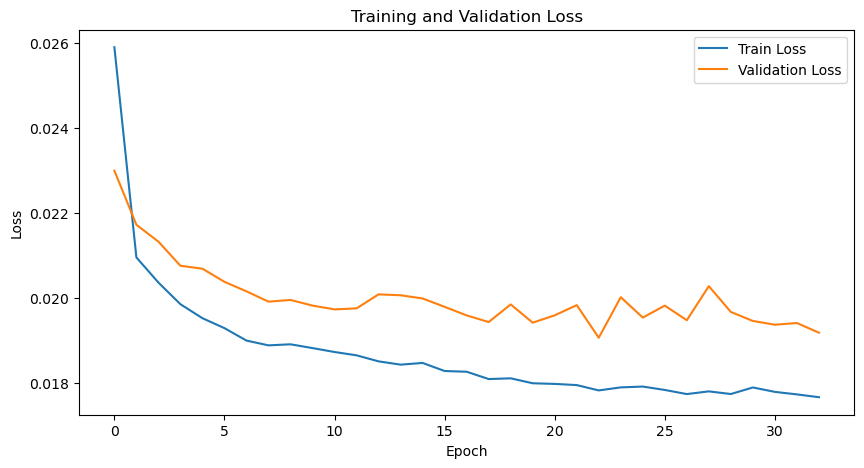

In [ ]:
# train the model
model_baseline = CNNPlusLinear()

model_baseline, metrics_baseline = trainer.train_model(
    model_baseline,
    train_loader,
    val_loader,
    compute_r2,
    compute_pearsonr,
    num_epochs=100,
    lr=1e-3,
    weight_decay=0.001,
    patience=10,
    save_plot_path='baseline_loss_plot.png',
    criterion=nn.MSELoss(),
    scheduler_patience=5,
    scheduler_factor=0.5,
    verbose=True,
)

In [8]:
# evaluate baseline on test set
model_baseline.eval().to('cuda')
running_test_loss = 0.0
y_preds = []
y_trues = []
criterion = nn.MSELoss()
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to('cuda'), y_batch.to('cuda')
        y_pred = model_baseline(x_batch)
        loss = criterion(y_pred, y_batch)
        running_test_loss += loss.item()

        y_preds.append(y_pred.cpu().numpy())
        y_trues.append(y_batch.cpu().numpy())

    test_loss = running_test_loss / len(test_loader)
    y_preds = np.concatenate(y_preds, axis=0)
    y_trues = np.concatenate(y_trues, axis=0)
    r2_score = compute_r2(y_trues, y_preds)
    pearson_score = compute_pearsonr(y_trues, y_preds)
    print(f"Test Loss: {test_loss:.4f}, R2: {r2_score:.4f}, Pearson: {pearson_score:.4f}")

Test Loss: 0.0186, R2: 0.5945, Pearson: 0.7730


### UNI Baseline

In [10]:
## instantiate a uni model
timm_kwargs = {
   'img_size': 224,
   'patch_size': 32,
   'depth': 24,
   'num_heads': 24,
   'init_values': 1e-5,
   'embed_dim': 1536,
   'mlp_ratio': 2.66667*2,
   'num_classes': 0,
   'no_embed_class': True,
   'mlp_layer': timm.layers.SwiGLUPacked,
   'act_layer': torch.nn.SiLU,
   'reg_tokens': 8,
   'dynamic_img_size': True
  }
model_uni = timm.create_model("hf-hub:MahmoodLab/UNI2-h", pretrained=True, **timm_kwargs)
model_uni = model_uni.to('cuda')

# define new transform for uni
transform = create_transform(**resolve_data_config(model_uni.pretrained_cfg, model=model_uni))
model_uni.eval()

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1536, kernel_size=(32, 32), stride=(32, 32))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1536, out_features=1536, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (mlp): GluMlp(
        (fc1): Linear(in_features=1536, out_features=8192, bias=True)
        (act): SiLU()
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
    

In [11]:
# transform pil to tensor and normalize /255, tensorize expression vectors
patch_tensors_train = [transform(patch) for patch in patch_train]
expr_tensors_train = [torch.tensor(e, dtype=torch.float32) for e in expr_train]
patch_tensors_val = [transform(patch) for patch in patch_val]
expr_tensors_val = [torch.tensor(e, dtype=torch.float32) for e in expr_val]
patch_tensors_test = [transform(patch) for patch in patch_test]
expr_tensors_test = [torch.tensor(e, dtype=torch.float32) for e in expr_test]

# get features with uni
with torch.no_grad():
    patch_tensors_train = [model_uni(patch.unsqueeze(0).to('cuda')).cpu().squeeze(0) for patch in patch_tensors_train]
    patch_tensors_val = [model_uni(patch.unsqueeze(0).to('cuda')).cpu().squeeze(0) for patch in patch_tensors_val]
    patch_tensors_test = [model_uni(patch.unsqueeze(0).to('cuda')).cpu().squeeze(0) for patch in patch_tensors_test]
    
# assemble
train_dataset = TensorDataset(torch.stack(patch_tensors_train), torch.stack(expr_tensors_train))
val_dataset = TensorDataset(torch.stack(patch_tensors_val), torch.stack(expr_tensors_val))
test_dataset = TensorDataset(torch.stack(patch_tensors_test), torch.stack(expr_tensors_test))

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# train the model
model_uni_baseline = nn.Sequential(
    nn.Linear(1536, 1024),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 460),
).to('cuda')

model_uni_baseline, metrics_uni_baseline = trainer.train_model(
    model_uni_baseline,
    train_loader,
    val_loader,
    compute_r2,
    compute_pearsonr,
    num_epochs=100,
    lr=1e-3,
    weight_decay=0.001,
    patience=10,
    save_plot_path='uni_baseline_loss_plot.png',
    criterion=nn.MSELoss(),
    scheduler_patience=5,
    scheduler_factor=0.5,
    verbose=True,
)

/home/b-evelyntong/miniconda3/envs/gutinstinct/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.0182, Val Loss: 0.0172, R2: 0.6482, Pearson: 0.8044
Epoch 2/100, Train Loss: 0.0150, Val Loss: 0.0170, R2: 0.6520, Pearson: 0.8083
Epoch 3/100, Train Loss: 0.0145, Val Loss: 0.0167, R2: 0.6611, Pearson: 0.8128
Epoch 4/100, Train Loss: 0.0143, Val Loss: 0.0167, R2: 0.6634, Pearson: 0.8157


KeyboardInterrupt: 

In [ ]:
# evaluate baseline on test set
model_uni_baseline.eval().to('cuda')
criterion = nn.MSELoss()
running_test_loss = 0.0
y_preds = []
y_trues = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to('cuda'), y_batch.to('cuda')
        y_pred = model_uni_baseline(x_batch)
        loss = criterion(y_pred, y_batch)
        running_test_loss += loss.item()

        y_preds.append(y_pred.cpu().numpy())
        y_trues.append(y_batch.cpu().numpy())

    test_loss = running_test_loss / len(test_loader)
    y_preds = np.concatenate(y_preds, axis=0)
    y_trues = np.concatenate(y_trues, axis=0)
    r2_score = compute_r2(y_trues, y_preds)
    pearson_score = compute_pearsonr(y_trues, y_preds)
    print(f"Test Loss: {test_loss:.4f}, R2: {r2_score:.4f}, Pearson: {pearson_score:.4f}")

Test Loss: 0.0124, R2: 0.7590, Pearson: 0.8686


### Finetuning UNi
We have good motivation - the original task was entirely at the phenotypical / image level, not collecting information for the goal of predicting expression, so maybe the features extracted in the last layer aren't quite exactly what we need to get good expression prediction

In [ ]:
# finetune uni
import torch.nn as nn

class FinetunedUni(nn.Module):
    def __init__(self, base_model, num_classes):
        super().__init__()
        self.base = base_model
        self.head = nn.Linear(base_model.num_features, num_classes)
    
    def forward(self, x):
        x = self.base(x)
        x = self.head(x)
        return x

# instantiate
model_finetune = FinetunedUni(model_uni, num_classes=460).to('cuda')
transform = create_transform(**resolve_data_config(model_uni.pretrained_cfg, model=model_finetune))
model_finetune.train()

# let's unfreeze the last two blocks of the uni model
for name, param in model_finetune.named_parameters():
    if any(f"blocks.{i}" in name for i in range(22, 24)):
        param.requires_grad = True
    else:
        param.requires_grad = False

# check the number of trainable parameters
num_trainable = sum(p.numel() for p in model_finetune.parameters() if p.requires_grad)
num_total = sum(p.numel() for p in model_finetune.parameters())
print(f"Number of trainable parameters: {num_trainable} out of {num_total} total parameters")

Number of trainable parameters: 56673280 out of 685598668 total parameters


In [ ]:
# remake dataloaders for finetuning
patch_tensors_train = [transform(patch) for patch in patch_train]
expr_tensors_train = [torch.tensor(e, dtype=torch.float32) for e in expr_train]
patch_tensors_val = [transform(patch) for patch in patch_val]
expr_tensors_val = [torch.tensor(e, dtype=torch.float32) for e in expr_val]
patch_tensors_test = [transform(patch) for patch in patch_test]
expr_tensors_test = [torch.tensor(e, dtype=torch.float32) for e in expr_test]
    
# assemble
train_dataset = TensorDataset(torch.stack(patch_tensors_train), torch.stack(expr_tensors_train))
val_dataset = TensorDataset(torch.stack(patch_tensors_val), torch.stack(expr_tensors_val))
test_dataset = TensorDataset(torch.stack(patch_tensors_test), torch.stack(expr_tensors_test))

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Epoch 1/100, Train Loss: 0.0144, Val Loss: 0.0169, R2: 0.6581, Pearson: 0.8105
Epoch 2/100, Train Loss: 0.0129, Val Loss: 0.0167, R2: 0.6630, Pearson: 0.8154
Epoch 3/100, Train Loss: 0.0125, Val Loss: 0.0165, R2: 0.6685, Pearson: 0.8178
Epoch 4/100, Train Loss: 0.0122, Val Loss: 0.0164, R2: 0.6716, Pearson: 0.8195
Epoch 5/100, Train Loss: 0.0117, Val Loss: 0.0164, R2: 0.6714, Pearson: 0.8204
Epoch 6/100, Train Loss: 0.0114, Val Loss: 0.0163, R2: 0.6732, Pearson: 0.8212
Epoch 7/100, Train Loss: 0.0111, Val Loss: 0.0162, R2: 0.6764, Pearson: 0.8230
Epoch 8/100, Train Loss: 0.0107, Val Loss: 0.0166, R2: 0.6709, Pearson: 0.8206
Epoch 9/100, Train Loss: 0.0103, Val Loss: 0.0169, R2: 0.6612, Pearson: 0.8191
Epoch 10/100, Train Loss: 0.0099, Val Loss: 0.0168, R2: 0.6684, Pearson: 0.8206
Epoch 11/100, Train Loss: 0.0095, Val Loss: 0.0163, R2: 0.6788, Pearson: 0.8241
Epoch 12/100, Train Loss: 0.0092, Val Loss: 0.0163, R2: 0.6811, Pearson: 0.8255
Epoch 13/100, Train Loss: 0.0087, Val Loss: 0.016

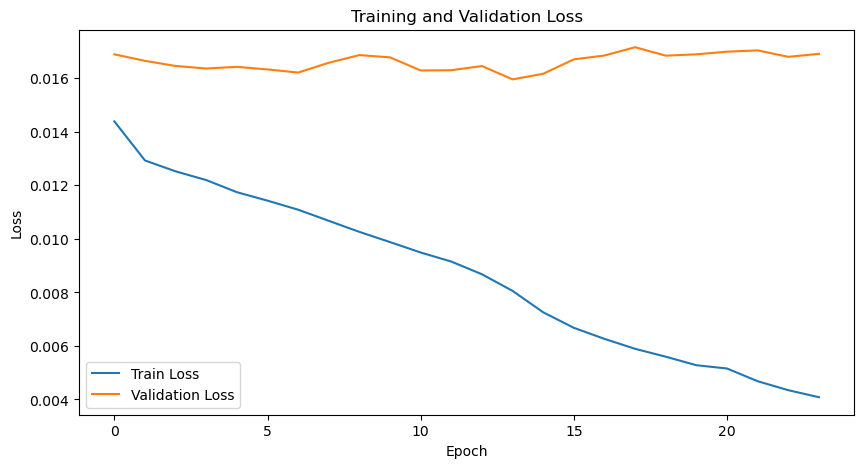

In [ ]:
# config
n_epoch = 100
optimizer = optim.Adam(model_finetune.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
criterion = nn.MSELoss()

# early stopping
early_stopping_patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None

train_losses, val_losses = [], []
r2_scores, pearson_scores = [], []

for epoch in range(n_epoch):
    # train
    running_train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to('cuda'), y_batch.to('cuda')
        optimizer.zero_grad()
        y_pred = model_finetune(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    train_loss = running_train_loss / len(train_loader)
    train_losses.append(train_loss)

    # validate
    model_finetune.eval()
    running_val_loss = 0.0
    y_preds = []
    y_trues = []
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to('cuda'), y_batch.to('cuda')
            y_pred = model_finetune(x_batch)
            loss = criterion(y_pred, y_batch)
            running_val_loss += loss.item()

            y_preds.append(y_pred.cpu().numpy())
            y_trues.append(y_batch.cpu().numpy())

        val_loss = running_val_loss / len(val_loader)
        val_losses.append(val_loss)

    # metrics
    y_preds = np.concatenate(y_preds, axis=0)
    y_trues = np.concatenate(y_trues, axis=0)
    r2_score = compute_r2(y_trues, y_preds)
    pearson_score = compute_pearsonr(y_trues, y_preds)
    r2_scores.append(r2_score)
    pearson_scores.append(pearson_score)

    # log and es
    print(f"Epoch {epoch+1}/{n_epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, R2: {r2_score:.4f}, Pearson: {pearson_score:.4f}")
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = deepcopy(model_finetune.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

if best_model_state is not None:
    model_finetune.load_state_dict(best_model_state)
    print("Best model restored.")

# plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig("finetuning_uni_loss_plot.png")
plt.show()

In [ ]:
# save the model
torch.save(model_finetune.state_dict(), 'finetuned_uni_model.pth')

# load the model
model_finetune.load_state_dict(torch.load('finetuned_uni_model.pth'))
model_finetune = model_finetune.to('cuda')

# define new transform for uni
transform = create_transform(**resolve_data_config(model_finetune.base.pretrained_cfg, model=model_finetune.base))
model_finetune.eval()

FinetunedUni(
  (base): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1536, kernel_size=(32, 32), stride=(32, 32))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1536, out_features=4608, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1536, out_features=1536, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
        (mlp): GluMlp(
          (fc1): Linear(in_features=1536, out_features=8192, bias=True)
          (act): SiLU()
      

### Finetuned UNI

In [ ]:
# we now use the finetuned model to get features
# transform pil to tensor and normalize /255, tensorize expression vectors
patch_tensors_train = [transform(patch) for patch in patch_train]
expr_tensors_train = [torch.tensor(e, dtype=torch.float32) for e in expr_train]
patch_tensors_val = [transform(patch) for patch in patch_val]
expr_tensors_val = [torch.tensor(e, dtype=torch.float32) for e in expr_val]
patch_tensors_test = [transform(patch) for patch in patch_test]
expr_tensors_test = [torch.tensor(e, dtype=torch.float32) for e in expr_test]

# get features with uni
with torch.no_grad():
    patch_tensors_train = [model_finetune.base(patch.unsqueeze(0).to('cuda')).cpu().squeeze(0) for patch in patch_tensors_train]
    patch_tensors_val = [model_finetune.base(patch.unsqueeze(0).to('cuda')).cpu().squeeze(0) for patch in patch_tensors_val]
    patch_tensors_test = [model_finetune.base(patch.unsqueeze(0).to('cuda')).cpu().squeeze(0) for patch in patch_tensors_test]
    
# assemble
train_dataset = TensorDataset(torch.stack(patch_tensors_train), torch.stack(expr_tensors_train))
val_dataset = TensorDataset(torch.stack(patch_tensors_val), torch.stack(expr_tensors_val))
test_dataset = TensorDataset(torch.stack(patch_tensors_test), torch.stack(expr_tensors_test))

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/home/b-evelyntong/miniconda3/envs/gutinstinct/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/100, Train Loss: 0.0171, Val Loss: 0.0172, R2: 0.6454, Pearson: 0.8075
Epoch 2/100, Train Loss: 0.0136, Val Loss: 0.0165, R2: 0.6665, Pearson: 0.8176
Epoch 3/100, Train Loss: 0.0131, Val Loss: 0.0166, R2: 0.6610, Pearson: 0.8166
Epoch 4/100, Train Loss: 0.0130, Val Loss: 0.0166, R2: 0.6643, Pearson: 0.8177
Epoch 5/100, Train Loss: 0.0128, Val Loss: 0.0163, R2: 0.6728, Pearson: 0.8223
Epoch 6/100, Train Loss: 0.0127, Val Loss: 0.0163, R2: 0.6699, Pearson: 0.8217
Epoch 7/100, Train Loss: 0.0127, Val Loss: 0.0162, R2: 0.6757, Pearson: 0.8233
Epoch 8/100, Train Loss: 0.0126, Val Loss: 0.0160, R2: 0.6800, Pearson: 0.8256
Epoch 9/100, Train Loss: 0.0126, Val Loss: 0.0163, R2: 0.6740, Pearson: 0.8240
Epoch 10/100, Train Loss: 0.0126, Val Loss: 0.0160, R2: 0.6804, Pearson: 0.8258
Epoch 11/100, Train Loss: 0.0126, Val Loss: 0.0160, R2: 0.6792, Pearson: 0.8255
Epoch 12/100, Train Loss: 0.0126, Val Loss: 0.0159, R2: 0.6807, Pearson: 0.8261
Epoch 13/100, Train Loss: 0.0127, Val Loss: 0.016

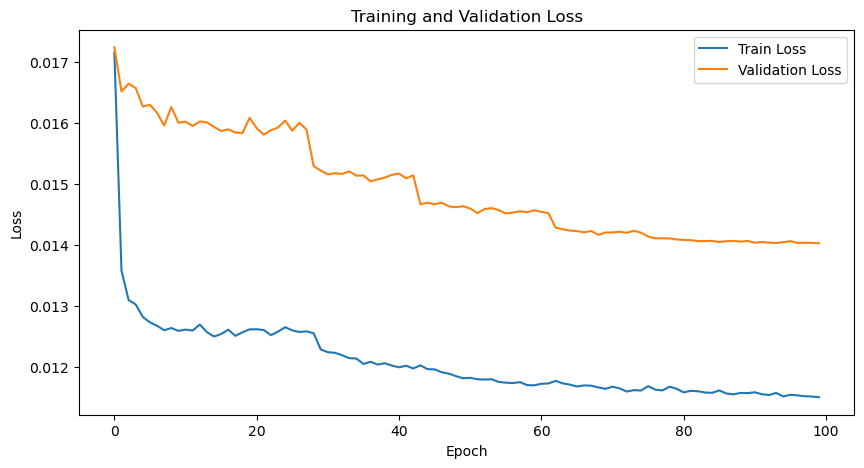

In [ ]:
# train the model
model_uni_fintuned = nn.Sequential(
    nn.Linear(1536, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 460),
).to('cuda')

model_uni_fintuned, metrics_uni_finetuned = trainer.train_model(
    model_uni_fintuned,
    train_loader,
    val_loader,
    compute_r2,
    compute_pearsonr,
    num_epochs=100,
    lr=1e-3,
    weight_decay=0.001,
    patience=10,
    save_plot_path='uni_finetuned_loss_plot.png',
    criterion=nn.MSELoss(),
    scheduler_patience=5,
    scheduler_factor=0.5,
    verbose=True,
)


In [ ]:
# evaluate baseline on test set
model_uni_fintuned.eval()
model_uni_fintuned.to('cuda')
running_test_loss = 0.0
y_preds = []
y_trues = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch, y_batch = x_batch.to('cuda'), y_batch.to('cuda')
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        running_test_loss += loss.item()

        y_preds.append(y_pred.cpu().numpy())
        y_trues.append(y_batch.cpu().numpy())

    test_loss = running_test_loss / len(test_loader)
    y_preds = np.concatenate(y_preds, axis=0)
    y_trues = np.concatenate(y_trues, axis=0)
    r2_score = compute_r2(y_trues, y_preds)
    pearson_score = compute_pearsonr(y_trues, y_preds)
    print(f"Test Loss: {test_loss:.4f}, R2: {r2_score:.4f}, Pearson: {pearson_score:.4f}")

Test Loss: 0.0133, R2: 0.7353, Pearson: 0.8561
